# Objective:
### I want to produce a time series of all my '202X_liked_songs' playlists from 2018 to 2023 to measure trends in spotify analytics like: `valance`, `danceability`, `happiness`, etc. in my music preferences.


In [1]:
import pandas as pd
import numpy as np
import json
import os

### `fun main(effort) {`
    #let's begin
`}`

## Helper Functions

In [2]:
def appendPlaylsit(playlist: pd.Series, playlistName: str, master: pd.DataFrame) -> pd.DataFrame:
    '''
    Appends the songs and playlist info of a playlist to the master dataframe
    '''
    staging = []
    for track in playlist:
        trackDetails = track['track']
        newRow = {
            'playlist': playlistName, 
            'trackName': trackDetails['trackName'], 
            'artistName': trackDetails['artistName'],
            'albumName': trackDetails['albumName'], 
            'trackUri': trackDetails['trackUri'],
            }
        staging.append(newRow)
    df_staging = pd.DataFrame(staging, columns=master.columns)
    return pd.concat([master, df_staging], ignore_index=True)


def appendCurrentPlaylist(playlist: dict, playlistName: str, master: pd.DataFrame) -> pd.DataFrame:
    '''
    Appends the song and playlist info of the current year's "Liked Songs" playlist
    to the master dataframe.
    '''
    staging = []
    for track in playlist['tracks']:
        newRow = {
            'playlist': playlistName,
            'trackName': track['track'],
            'artistName': track['artist'],
            'albumName': track['album'], 
            'trackUri': track['uri'],
            }
        staging.append(newRow)
    df_staging = pd.DataFrame(staging, columns=master.columns)
    return pd.concat([master, df_staging], ignore_index=True)


def getCurrentPlaylist(path: str):
    with open(path, encoding='utf-8') as json_data:
        data = json.load(json_data)
        return data
    

def getStreamHistory(extendedDataPath: str, historyFilePath: str) -> pd.DataFrame:
    return (pd.read_json(os.path.join(extendedDataPath, historyFilePath))
            .drop(columns=[
                'username',
                'platform',
                'conn_country',
                'ip_addr_decrypted',
                'user_agent_decrypted',
                'master_metadata_album_album_name',
                'episode_name','episode_show_name',
                'spotify_episode_uri',
                'incognito_mode',
                ],
                  )
            .rename(columns={
                'ts': 'timeStamp',
                'ms_played': 'msPlayed',
                'master_metadata_track_name': 'trackName',
                'master_metadata_album_artist_name': 'artistName',
                'spotify_track_uri': 'trackUri',
                'reason_start': 'reasonStart',
                'reason_end': 'reasonEnd',
                'offline_timestamp': 'offlineTimestamp'
                },
                    )
            )
    

def getMasterStreamData(extendedDataPath: str) -> pd.DataFrame:
    staging = []
    with os.scandir(extendedDataPath) as entries:
        for entry in entries:
            if not 'Audio' in entry.name or entry.is_dir():
                continue
            staging.append(getStreamHistory(extendedDataPath, entry.name))
    df = pd.concat(staging, ignore_index=True)
    df['timeStamp'] = pd.to_datetime(df['timeStamp'])
    return df


## Filepaths

In [3]:
shortDataPath = os.path.join(os.getcwd(), 'short_data')
extendedDataPath = os.path.join(os.getcwd(), 'extended_data')
        
historicalPlaylistDataPath = os.path.join(shortDataPath, 'Playlist1.json')
currentPlaylistDataPath = os.path.join(shortDataPath, 'YourLibrary.json')
extendedPlaylistHistory = os.path.join(extendedDataPath, 'Streaming_History_Audio_2018-2020_0.json')

hist = pd.read_json(historicalPlaylistDataPath)
curr = getCurrentPlaylist(currentPlaylistDataPath)

### Extracting historical playlists

In [4]:
likedSongs_2022 = pd.DataFrame(hist.iloc[0,0])['items']
likedSongs_2021 = pd.DataFrame(hist.iloc[7,0])['items']
likedSongs_2020 = pd.DataFrame(hist.iloc[9,0])['items']
likedSongs_2019 = pd.DataFrame(hist.iloc[10,0])['items']

## Constructing and appending to Master Playlist DataFrame: `likedSongs`

In [5]:
likedSongs = pd.DataFrame({
    'playlist': [],
    'trackName': [],
    'artistName': [],
    'albumName': [],
    'trackUri': [],
    })
likedSongs = appendPlaylsit(likedSongs_2019, 'likedSongs_2019', likedSongs)
likedSongs = appendPlaylsit(likedSongs_2020, 'likedSongs_2020', likedSongs)
likedSongs = appendPlaylsit(likedSongs_2021, 'likedSongs_2021', likedSongs)
likedSongs = appendPlaylsit(likedSongs_2022, 'likedSongs_2022', likedSongs)
likedSongs = appendCurrentPlaylist(curr, 'likedSongs_2023', likedSongs)

## Constructing Master Stream History DataFrame: `streamHistory`

In [6]:
streamHistory = getMasterStreamData(extendedDataPath)
streamHistory

,timeStamp,msPlayed,trackName,artistName,trackUri,reasonStart,reasonEnd,shuffle,skipped,offline,offlineTimestamp
0,2018-04-26 19:42:02+00:00,63764,Fast Car,Tracy Chapman,spotify:track:2M9ro2krNb7nr7HSprkEgo,clickrow,endplay,False,NaN,False,1524771654614
1,2018-04-26 19:44:01+00:00,117560,Crazy In Love (feat. Jay-Z),Beyoncé,spotify:track:5IVuqXILoxVWvWEPm82Jxr,clickrow,endplay,False,NaN,False,1524771721536
2,2018-04-26 19:45:12+00:00,70817,Ignition - Remix,R. Kelly,spotify:track:5dNfHmqgr128gMY2tc5CeJ,clickrow,fwdbtn,False,NaN,False,1524771839733
3,2018-04-26 19:45:14+00:00,1417,Billie Jean,Michael Jackson,spotify:track:5ChkMS8OtdzJeqyybCc9R5,fwdbtn,backbtn,False,NaN,False,1524771910986
4,2018-04-26 19:45:39+00:00,25128,Ignition - Remix,R. Kelly,spotify:track:5dNfHmqgr128gMY2tc5CeJ,backbtn,endplay,False,NaN,False,1524771912972
...,...,...,...,...,...,...,...,...,...,...,...
78105,2023-06-26 20:30:37+00:00,146973,Land of 1000 Dances,Wilson Pickett,spotify:track:76ICmoJ4PcoMWoooaTxnQs,trackdone,trackdone,True,0.0,False,1687811289
78106,2023-06-26 20:33:22+00:00,164173,Spooky,Dusty Springfield,spotify:track:3MtP9T0WF4xbIo8vqHYeXM,trackdone,trackdone,True,0.0,False,1687811437
78107,2023-06-26 20:58:53+00:00,296990,Give Up The Funk (Tear The Roof Off The Sucker),Parliament,spotify:track:4XRkQloZFcRrCONN7ZQ49Y,trackdone,logout,True,0.0,False,1687811632
78108,2023-06-26 21:03:01+00:00,236293,King For A Day,Pierce The Veil,spotify:track:1IT0WQk5J8NsaeII8ktdlZ,playbtn,endplay,False,1.0,False,1687813147


## Two DataFrames: `likedSongs` and `streamHistory`

In [7]:
likedSongs

,playlist,trackName,artistName,albumName,trackUri
0,likedSongs_2019,Dance Monkey,Tones And I,Welcome To The Madhouse,spotify:track:2N8m6CYs74qQO4mjVcXO30
1,likedSongs_2019,Nurse's Office,Melanie Martinez,K-12,spotify:track:4fRzunTZ51UC0oNwoVqiKB
2,likedSongs_2019,Walls Could Talk,Halsey,hopeless fountain kingdom,spotify:track:5ln5yQdUywVbf8HhFsOcd6
3,likedSongs_2019,South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,South of the Border (feat. Camila Cabello & Ca...,spotify:track:3vQhEd4lOg4mAV6CHCgoHW
4,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe),spotify:track:7IOuCLt770D8v0u3SVaDeI
...,...,...,...,...,...
294,likedSongs_2023,On Your Mind,Noah Floersch,On Your Mind,spotify:track:4RPSs5aQymn0A5syaHE7VI
295,likedSongs_2023,Lux Æterna,Metallica,Screaming Suicide,spotify:track:5iHkCqQsOafegfMl9r7EqA
296,likedSongs_2023,Moscow,Grace McLean,"Natasha, Pierre & the Great Comet of 1812 (Ori...",spotify:track:0biYtKfzPKpMRjInRJuNpn
297,likedSongs_2023,ABC (feat. Sophia Black),Polyphia,Remember That You Will Die,spotify:track:4c8TMfsKJIrRgCWs8LCEbQ


In [29]:
merged = streamHistory.merge(likedSongs, on='trackUri', how='inner').drop_duplicates()
dateAddedInfo = merged.groupby(by='trackUri')['timeStamp'].agg(dateAdded=lambda x: x.iloc[1]) # Select the second stream of the song
final = likedSongs.merge(dateAddedInfo, on='trackUri', how='left')
final

,playlist,trackName,artistName,albumName,trackUri,dateAdded
0,likedSongs_2019,Dance Monkey,Tones And I,Welcome To The Madhouse,spotify:track:2N8m6CYs74qQO4mjVcXO30,2021-10-19 21:17:15+00:00
1,likedSongs_2019,Nurse's Office,Melanie Martinez,K-12,spotify:track:4fRzunTZ51UC0oNwoVqiKB,2019-10-24 18:44:59+00:00
2,likedSongs_2019,Walls Could Talk,Halsey,hopeless fountain kingdom,spotify:track:5ln5yQdUywVbf8HhFsOcd6,2019-11-04 13:09:10+00:00
3,likedSongs_2019,South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,South of the Border (feat. Camila Cabello & Ca...,spotify:track:3vQhEd4lOg4mAV6CHCgoHW,2019-10-27 22:49:53+00:00
4,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe),spotify:track:7IOuCLt770D8v0u3SVaDeI,2019-10-25 23:16:59+00:00
...,...,...,...,...,...,...
294,likedSongs_2023,On Your Mind,Noah Floersch,On Your Mind,spotify:track:4RPSs5aQymn0A5syaHE7VI,2022-09-26 13:37:44+00:00
295,likedSongs_2023,Lux Æterna,Metallica,Screaming Suicide,spotify:track:5iHkCqQsOafegfMl9r7EqA,2023-04-23 00:57:34+00:00
296,likedSongs_2023,Moscow,Grace McLean,"Natasha, Pierre & the Great Comet of 1812 (Ori...",spotify:track:0biYtKfzPKpMRjInRJuNpn,2020-12-09 16:21:08+00:00
297,likedSongs_2023,ABC (feat. Sophia Black),Polyphia,Remember That You Will Die,spotify:track:4c8TMfsKJIrRgCWs8LCEbQ,2023-06-25 04:55:13+00:00


[Text(0.5, 0, 'No. of Times Streamed'),
 Text(0, 0.5, 'No. of Songs in Bin'),
 Text(0.5, 1.0, 'Song Popularity Historgram')]

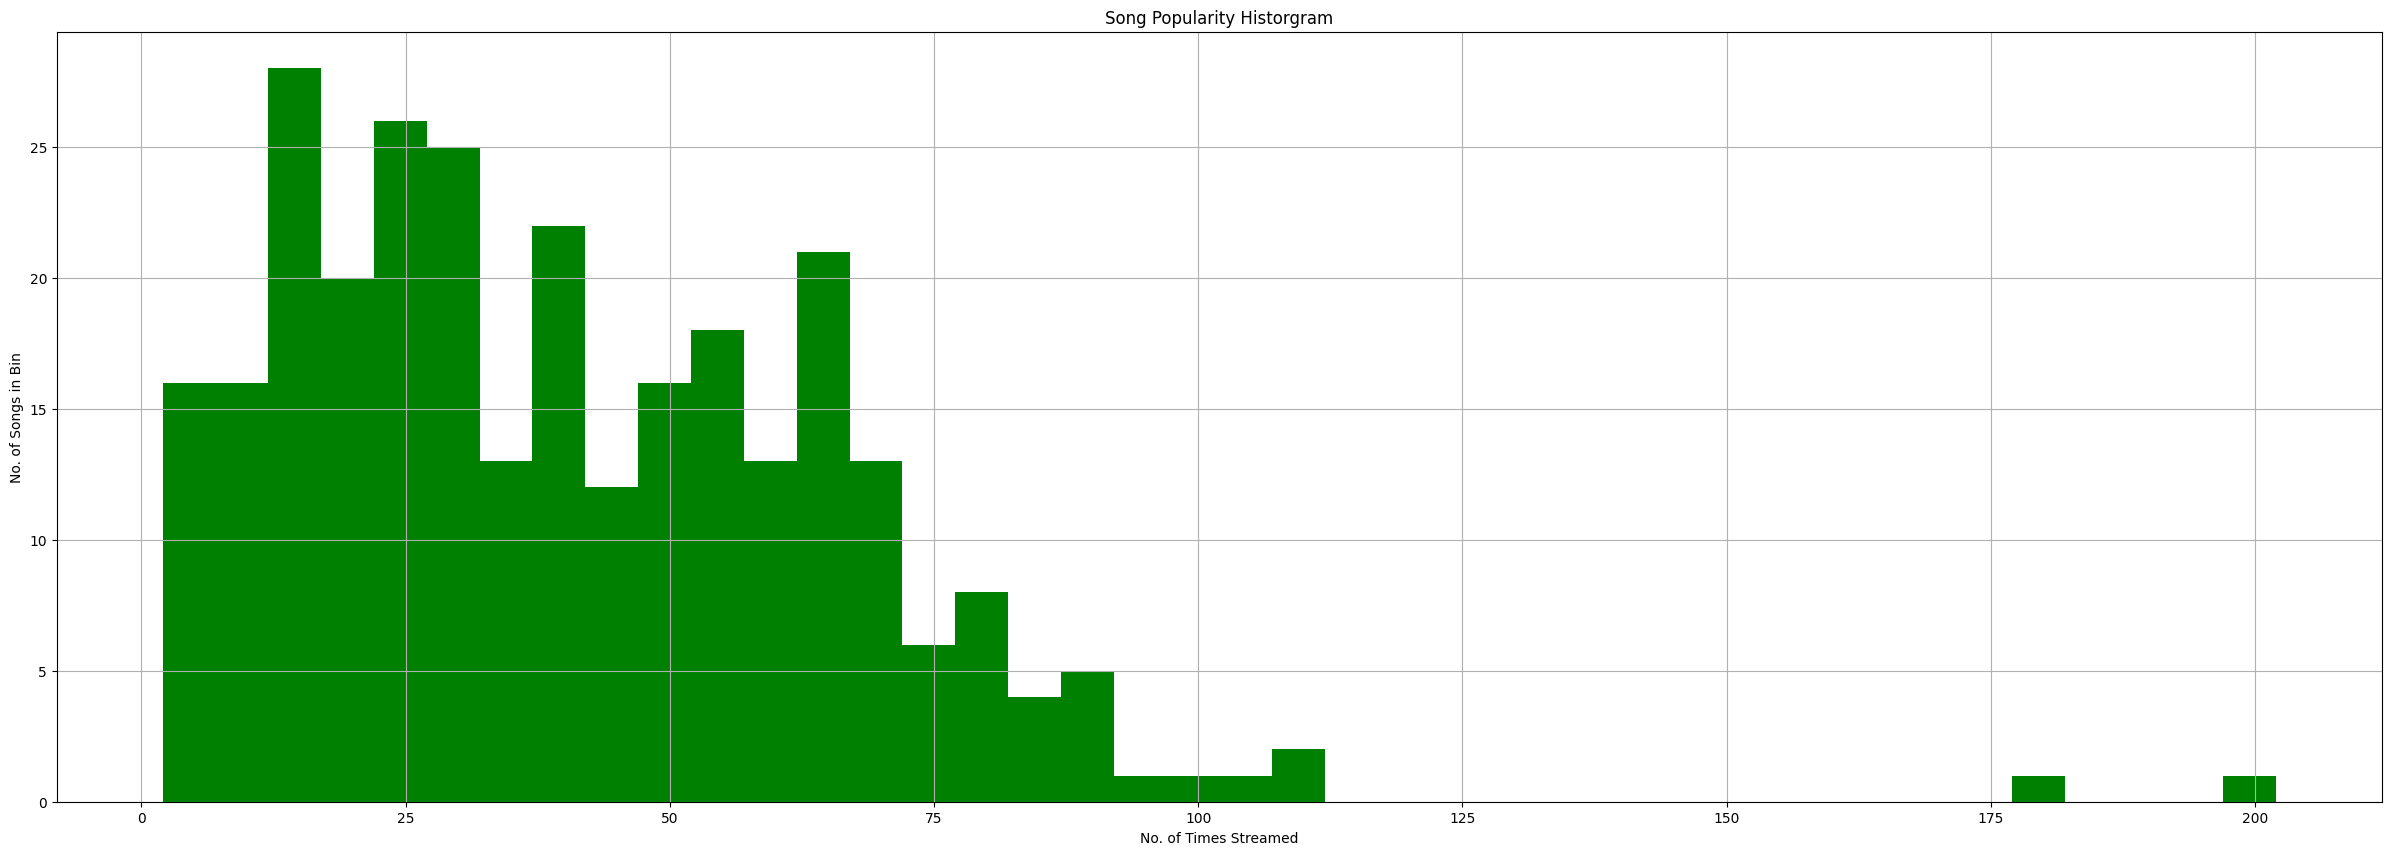

In [8]:
merged = streamHistory.merge(likedSongs, on='trackUri', how='inner').drop_duplicates()
counts = merged.groupby('trackUri', sort=True).size()
n = 9
ax = counts.hist(bins=40, figsize=(30, 10), color='green')#bins=102-n, figsize=(30, 10), range=(8, 102-n))
# ax.xaxis.set_ticks()#np.arange(8, 102-n, 5))
ax.set(xlabel='No. of Times Streamed', ylabel='No. of Songs in Bin', title='Song Popularity Historgram')

In [9]:
streamToLikeRatio = len(merged['timeStamp'].unique()) / len(streamHistory['timeStamp'].unique())
print(f'From 2019 - 2023[June] {streamToLikeRatio * 100:.2f}% of the songs I have streamed made it into my liked songs playlists.\nNot including those which went into separate playilists')

From 2019 - 2023[June] 14.62% of the songs I have streamed made it into my liked songs playlists.
Not including those which went into separate playilists


In [10]:
len(counts.where((75 <= counts) & (counts <= 125)).dropna())

22

[Text(0.5, 0, 'Unique Streams'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Song Popularity Historgram')]

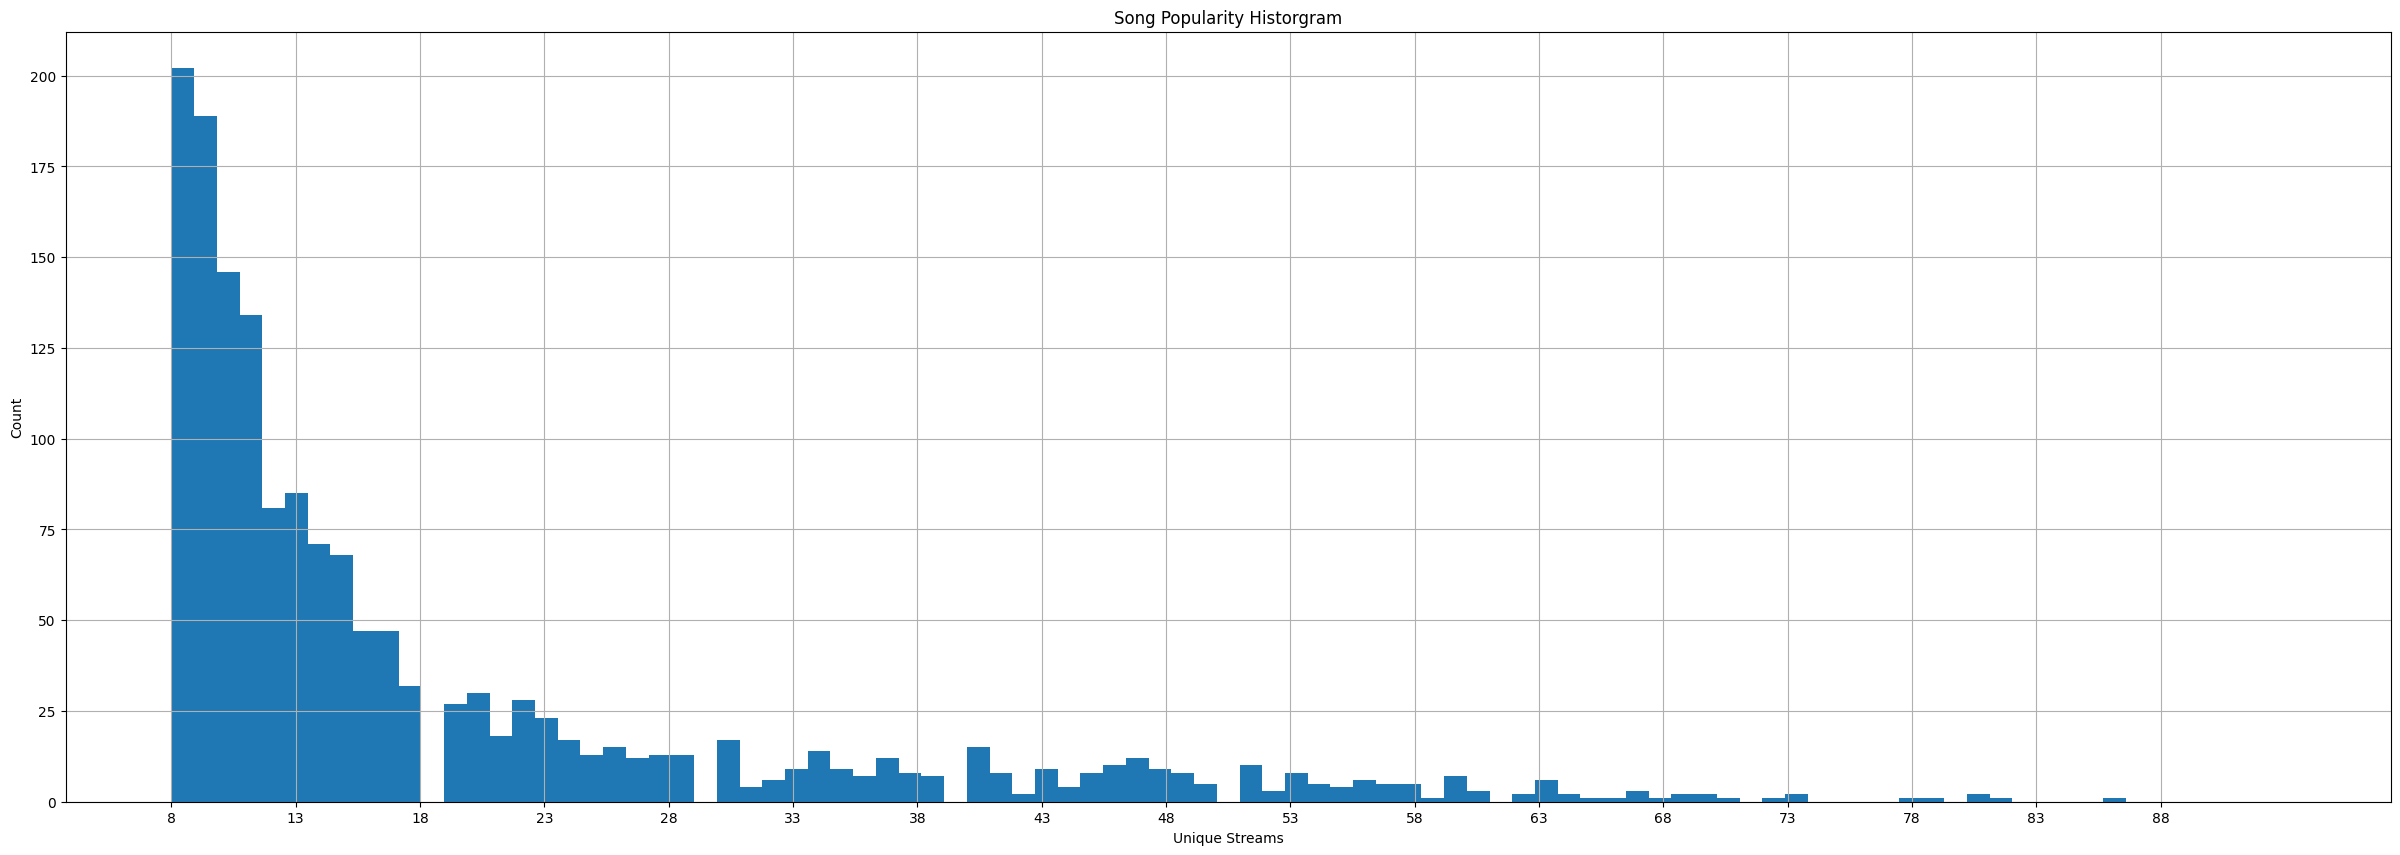

In [11]:
ser = streamHistory[['trackName', 'trackUri', 'reasonEnd']].value_counts()
# ser
# ser.where(ser == 23).dropna()
n = 9
ax = ser.hist(bins=102-n, figsize=(30, 10), range=(8, 102-n))
ax.xaxis.set_ticks(np.arange(8, 102-n, 5))
ax.set(xlabel='Unique Streams', ylabel='Count', title='Song Popularity Historgram')


In [31]:
streamHistory.loc[(streamHistory.trackUri == 'spotify:track:4RPSs5aQymn0A5syaHE7VI')]

,timeStamp,msPlayed,trackName,artistName,trackUri,reasonStart,reasonEnd,shuffle,skipped,offline,offlineTimestamp
70441,2022-09-26 13:37:44+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,trackdone,trackdone,True,NaN,False,1664199303741
70526,2022-09-27 11:56:01+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,clickrow,trackdone,True,NaN,False,1664279602251
70566,2022-09-29 18:42:30+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,clickrow,trackdone,False,NaN,False,1664476790170
70799,2022-10-03 14:43:46+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,trackdone,trackdone,True,NaN,False,1664808064656
71008,2022-10-08 10:44:07+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,trackdone,trackdone,False,NaN,False,1665225686963
71352,2022-10-20 15:05:20+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,trackdone,trackdone,False,0.0,False,1666278161
72793,2023-02-05 22:25:30+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,trackdone,trackdone,True,0.0,False,1675635770
76770,2023-05-27 16:59:38+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,trackdone,endplay,True,1.0,False,1685206618
76831,2023-05-29 11:04:20+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,trackdone,trackdone,True,0.0,False,1685358099
76952,2023-06-01 14:46:19+00:00,159600,On Your Mind,Noah Floersch,spotify:track:4RPSs5aQymn0A5syaHE7VI,trackdone,trackdone,True,0.0,False,1685630539


In [13]:
merged.loc[merged.trackUri == "spotify:track:7IOuCLt770D8v0u3SVaDeI"]

,timeStamp,msPlayed,trackName_x,artistName_x,trackUri,reasonStart,reasonEnd,shuffle,skipped,offline,offlineTimestamp,playlist,trackName_y,artistName_y,albumName
2910,2019-10-24 05:03:33+00:00,154786,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,trackdone,trackdone,False,NaN,False,1571893257030,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)
2911,2019-10-25 23:16:59+00:00,154786,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,clickrow,trackdone,True,NaN,False,1572045264397,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)
2912,2019-10-26 23:56:01+00:00,154786,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,trackdone,trackdone,False,NaN,False,1572134004499,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)
2913,2019-10-27 00:14:37+00:00,154786,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,clickrow,trackdone,False,NaN,False,1572135121233,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)
2914,2019-10-27 23:10:54+00:00,154786,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,trackdone,trackdone,False,NaN,False,1572217696652,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,2021-10-31 17:47:53+00:00,154786,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,trackdone,trackdone,False,NaN,False,1635702317053,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)
2983,2021-12-02 21:06:44+00:00,154786,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,trackdone,trackdone,True,NaN,False,1638479049240,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)
2984,2022-01-05 02:06:50+00:00,154785,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,trackdone,trackdone,True,NaN,False,1641348254025,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)
2985,2022-01-07 23:15:14+00:00,134562,Wasabi,Little Mix,spotify:track:7IOuCLt770D8v0u3SVaDeI,trackdone,logout,False,NaN,False,1641530056776,likedSongs_2019,Wasabi,Little Mix,LM5 (Deluxe)


## Isolating Unique Streams

In [14]:
help(merged.groupby("trackUri"))

Help on DataFrameGroupBy in module pandas.core.groupby.generic object:

class DataFrameGroupBy(pandas.core.groupby.groupby.GroupBy)
 |  DataFrameGroupBy(obj: 'NDFrameT', keys: '_KeysArgType | None' = None, axis: 'Axis' = 0, level: 'IndexLabel | None' = None, grouper: 'ops.BaseGrouper | None' = None, exclusions: 'frozenset[Hashable] | None' = None, selection: 'IndexLabel | None' = None, as_index: 'bool' = True, sort: 'bool' = True, group_keys: 'bool' = True, observed: 'bool' = False, dropna: 'bool' = True) -> 'None'
 |  
 |  Method resolution order:
 |      DataFrameGroupBy
 |      pandas.core.groupby.groupby.GroupBy
 |      pandas.core.groupby.groupby.BaseGroupBy
 |      pandas.core.base.PandasObject
 |      pandas.core.accessor.DirNamesMixin
 |      pandas.core.base.SelectionMixin
 |      typing.Generic
 |      pandas.core.groupby.indexing.GroupByIndexingMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, key) -> 'DataFrameGroupBy | SeriesGroupBy'
 